In [ ]:
#%%

# import os
# %load_ext autoreload
# %autoreload 2

## Do not preallocate GPU memory
# os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = '\"platform\"'

from nodax import *
# jax.config.update("jax_debug_nans", True)

## Execute jax on CPU
# jax.config.update("jax_platform_name", "cpu")


############# Neural Context Flow #############

Jax version: 0.4.35
Available devices: [CudaDevice(id=0)]


In [ ]:
#%%

seed = 2026
# seed = int(np.random.randint(0, 10000))

## Neural Context Flow hyperparameters ##
print_error_every = 1000
integrator = diffrax.Dopri5
# integrator = RK4
ivp_args = {"dt_init":1e-4, "rtol":1e-3, "atol":1e-6, "max_steps":4000, "subdivisions":5}
## subdivision is used for non-adaptive integrators like RK4. It's the number of extra steps to take between each evaluation time point
run_folder = "./18112024-123710-OnePerEnv/"

## Training hyperparameters ##
train = True
save_trainer = True

init_lr = 1e-4
sched_factor = 1.0

nb_epochs = 10000

## Adaptation hyperparameters ##
adapt_test = True
adapt_restore = True

init_lr_adapt = 5e-3
sched_factor_adapt = 0.5
nb_epochs_adapt = 1500

In [ ]:
#%%

if train == True:

    # check that 'tmp' folder exists. If not, create it
    if not os.path.exists('./runs'):
        os.mkdir('./runs')

    # Make a new folder inside 'tmp' whose name is the current time
    # run_folder = './runs/'+time.strftime("%d%m%Y-%H%M%S")+'/'
    run_folder = "./runs/18112024-123710-OnePerEnv/"
    # os.mkdir(run_folder)
    print("Run folder created successfuly:", run_folder)

    # Save the run and dataset scripts in that folder
    script_name = os.path.basename(__file__)
    os.system(f"cp {script_name} {run_folder}")
    os.system(f"cp dataset.py {run_folder}")

    # Save the nodax module files as well
    os.system(f"cp -r ../../nodax {run_folder}")
    print("Completed copied scripts ")

else:
    # run_folder = "./runs/22022024-112457/"  ## Needed for loading the model and finetuning TODO: opti
    print("No training. Loading data and results from:", run_folder)

## Create a folder for the adaptation results
adapt_folder = run_folder+"adapt/"
if not os.path.exists(adapt_folder):
    os.mkdir(adapt_folder)

Run folder created successfuly: ./runs/18112024-123710-OnePerEnv/
Completed copied scripts 


In [ ]:
#%%

if train == True:
    # Run the dataset script to generate the data
    os.system(f'python dataset.py --split=adapt --savepath="{run_folder}" --seed="{seed}"')
    os.system(f'python dataset.py --split=adapt_test --savepath="{run_folder}" --seed="{seed*2}"')

Running this script in ipython (Jupyter) session ? False
=== Parsed arguments to generate data ===
 Split: adapt
 Savepath: ./runs/18112024-123710-OnePerEnv/
 Seed: 2026

Running this script in ipython (Jupyter) session ? False
=== Parsed arguments to generate data ===
 Split: adapt_test
 Savepath: ./runs/18112024-123710-OnePerEnv/
 Seed: 4052



=== Performing one per environment (OPE) ... === 


Currently training from scratch for environment: 0 



Total number of parameters in the model: 49776 




=== Beginning training ... ===
    Number of examples in a batch: 1
    Number of train steps per epoch: 1
    Number of training epochs: 10000
    Total number of training steps: 10000

Compiling function "train_step" for neural ode ...
Shapes of elements in a batch: (1, 1, 40, 2) (40,)
    Epoch:     0      LossTrajs: 0.18509433     ContextsNorm: 0.00000000     ValIndCrit: 1.61367583
        Saving best model so far ...
    Epoch:     1      LossTrajs: 0.17104362     ContextsNorm: 0.00000000     ValIndCrit: 1.61277199
        Saving best model so far ...
    Epoch:     2      LossTrajs: 0.15849324     ContextsNorm: 0.00000000     ValIndCrit: 1.61296630
    Epoch:     3      LossTrajs: 0.14740241     ContextsNorm: 0.00000000     ValIndCrit: 1.61423063
    Epoch:  1000      LossTrajs: 0.07175197     ContextsNorm: 0.00000000     V

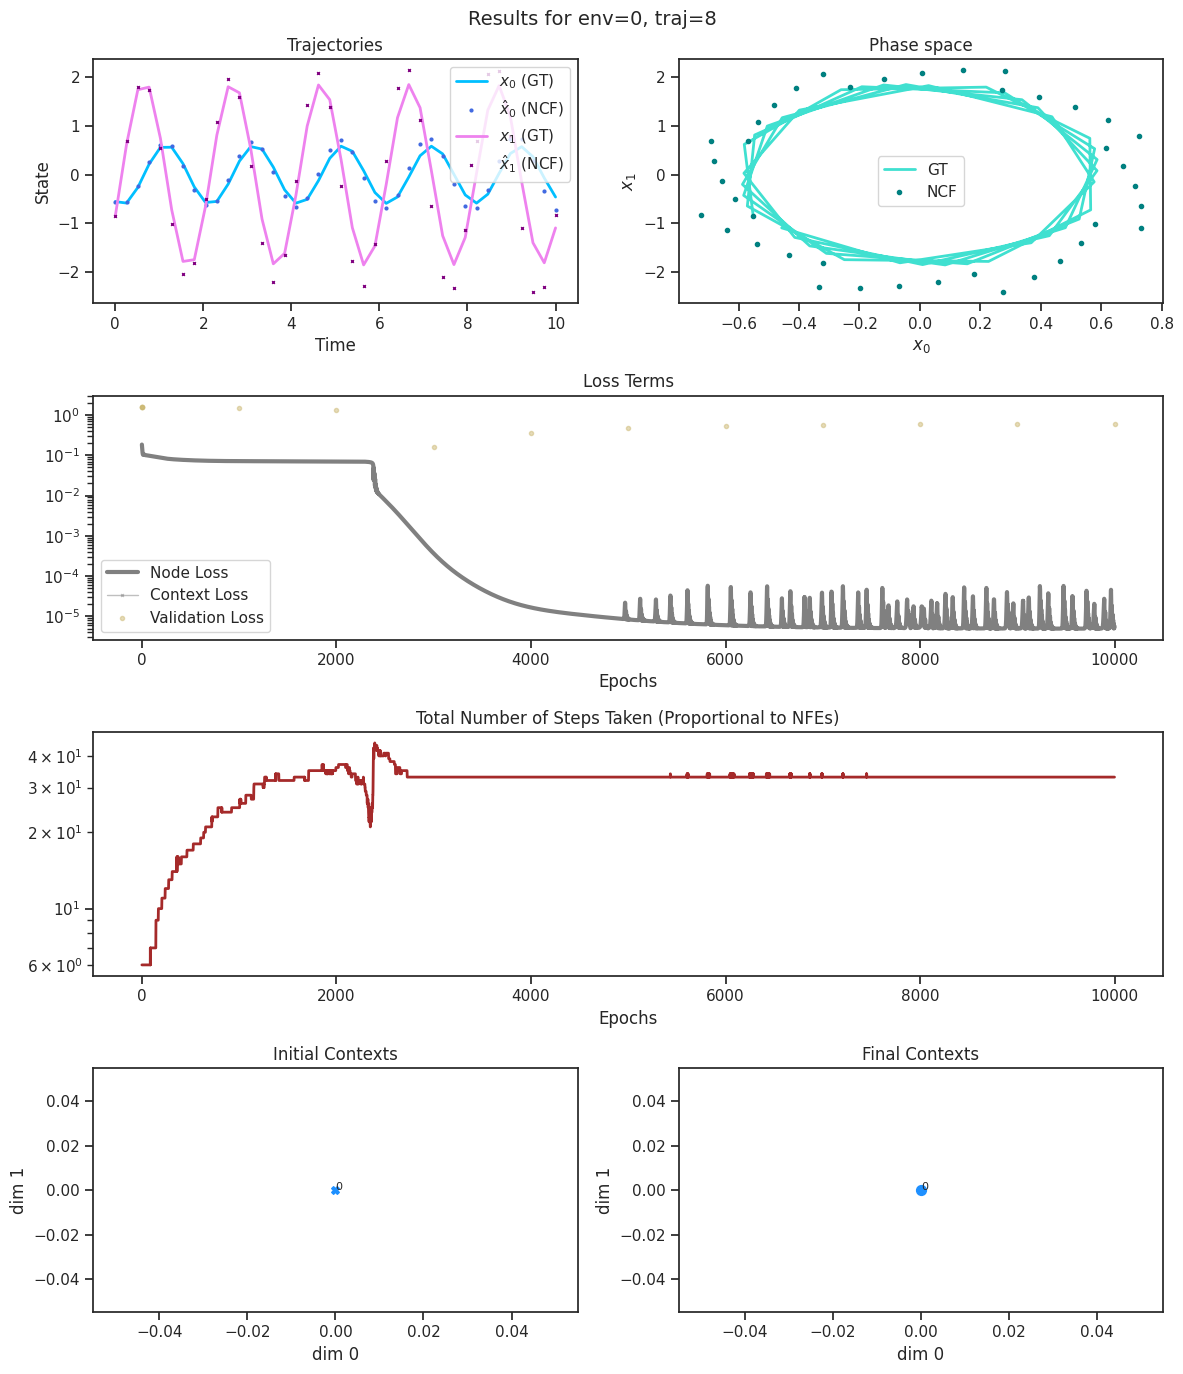

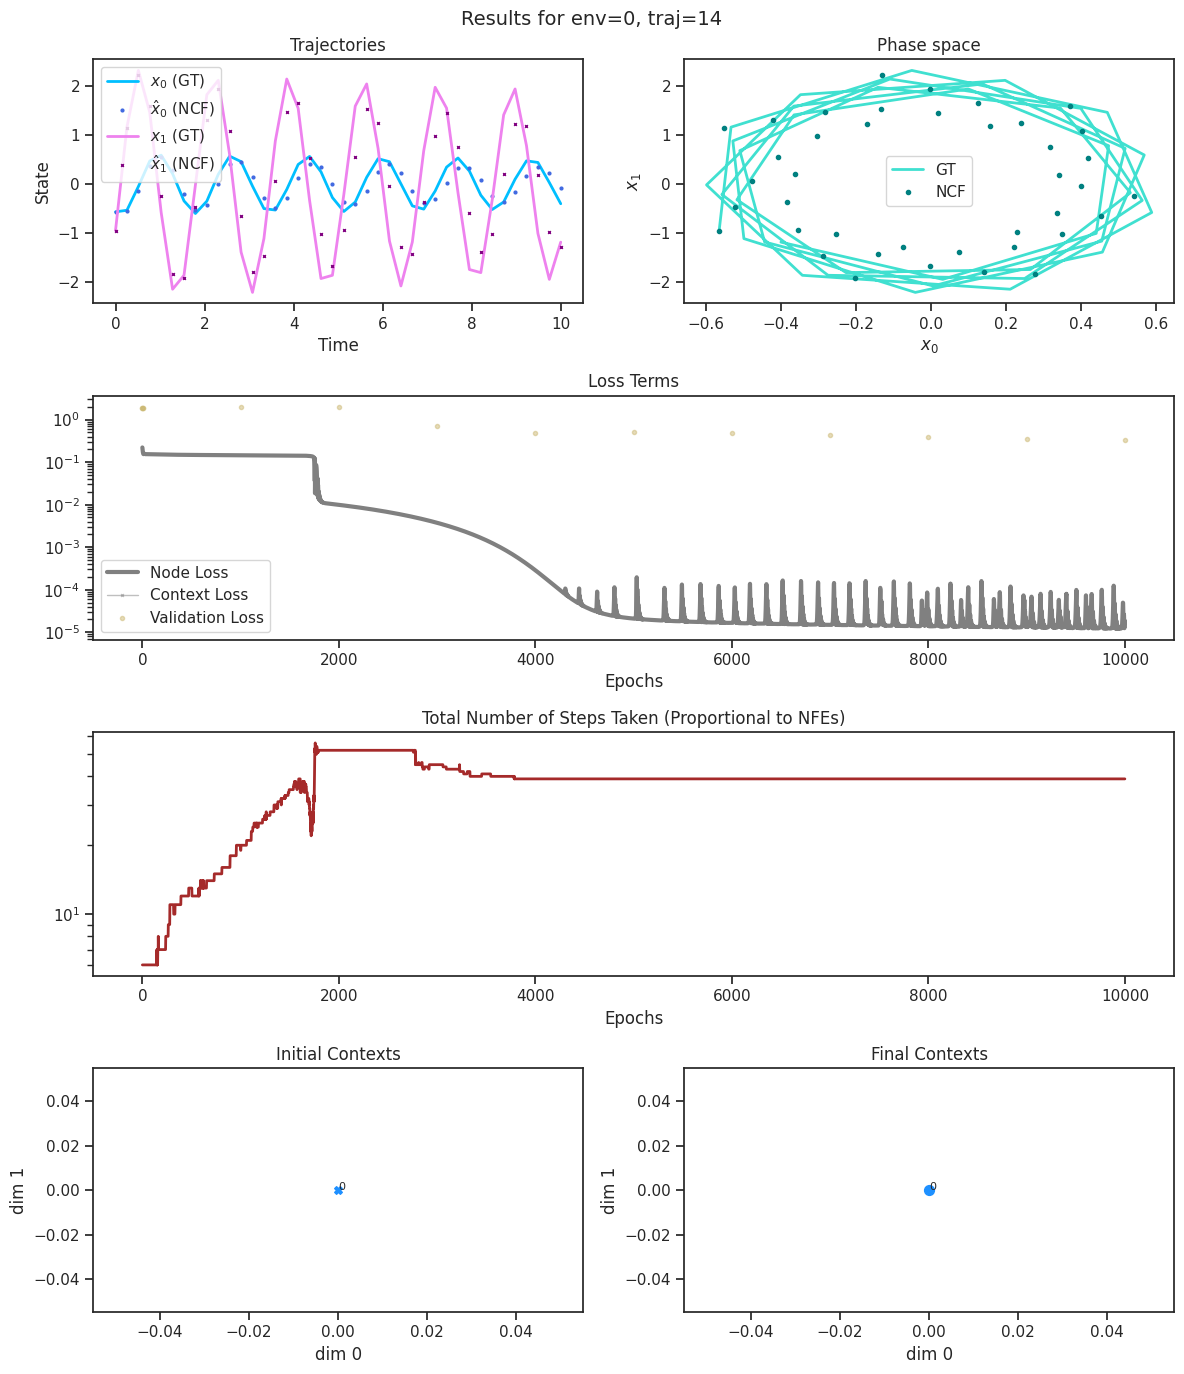

In [ ]:
#%%

print("=== Performing one per environment (OPE) ... === ")

adapt_mses = []

for adapt_env in range(2):      ## Two adaptation environments
    print(f"\n\nCurrently training from scratch for environment: {adapt_env} \n")

    ## Define dataloader for training and validation
    train_dataloader = DataLoader(run_folder+"adapt_data.npz", batch_size=-1, shuffle=True, key=seed)
    train_dataset = train_dataloader.dataset[adapt_env:adapt_env+1, ...]
    train_dataloader = DataLoader(dataset=train_dataset, t_eval=train_dataloader.t_eval, batch_size=-1, shuffle=True, key=seed)

    nb_envs = train_dataloader.nb_envs
    nb_trajs_per_env = train_dataloader.nb_trajs_per_env
    nb_steps_per_traj = train_dataloader.nb_steps_per_traj
    data_size = train_dataloader.data_size

    val_dataloader = DataLoader(run_folder+"adapt_test_data.npz", shuffle=False)
    val_dataset = val_dataloader.dataset[adapt_env:adapt_env+1, ...]
    val_dataloader = DataLoader(dataset=val_dataset, t_eval=val_dataloader.t_eval, batch_size=-1, shuffle=False, key=seed)

    ##%%

    val_dataloader.dataset.shape
    # plt.plot(val_dataloader.t_eval, val_dataloader.dataset[0, 0, :, 0])


    ##%%

    ## Define model and loss function for the learner
    class Swish(eqx.Module):
        beta: jnp.ndarray
        def __init__(self, key=None):
            self.beta = jax.random.uniform(key, shape=(1,), minval=0.01, maxval=1.0)
        def __call__(self, x):
            return x * jax.nn.sigmoid(self.beta * x)

    class Augmentation(eqx.Module):
        # layers_data: list
        layers_shared: list
        activations: list

        def __init__(self, data_size, int_size, context_size, key=None):
            keys = generate_new_keys(key, num=12)
            self.activations = [Swish(key=key_i) for key_i in keys[:7]]

            # self.layers_data = [eqx.nn.Linear(data_size, int_size, key=keys[3]), self.activations[2], 
            #                     eqx.nn.Linear(int_size, int_size, key=keys[4]), self.activations[3], 
            #                     eqx.nn.Linear(int_size, int_size, key=keys[5])]

            self.layers_shared = [eqx.nn.Linear(data_size, int_size, key=keys[6]), self.activations[4], 
                                eqx.nn.Linear(int_size, int_size, key=keys[7]), self.activations[5], 
                                eqx.nn.Linear(int_size, int_size, key=keys[8]), self.activations[6], 
                                eqx.nn.Linear(int_size, data_size, key=keys[9])]

        def __call__(self, t, y):

            # for layer in self.layers_data:
            #     y = layer(y)

            for layer in self.layers_shared:
                y = layer(y)

            return y


    class ContextFlowVectorField(eqx.Module):
        physics: eqx.Module
        augmentation: eqx.Module

        def __init__(self, augmentation, physics=None):
            self.augmentation = augmentation
            self.physics = physics

        def __call__(self, t, x, ctxs):
            return self.augmentation(t, x)


    augmentation = Augmentation(data_size=2, int_size=156, context_size=2, key=seed)

    # physics = Physics(key=seed)
    physics = None

    vectorfield = ContextFlowVectorField(augmentation, physics=physics)

    print("\n\nTotal number of parameters in the model:", sum(x.size for x in jax.tree_util.tree_leaves(eqx.filter(vectorfield,eqx.is_array)) if x is not None), "\n\n")

    contexts = ContextParams(nb_envs, 2, key=None)

    ## Define a custom loss function here
    def loss_fn_ctx(model, trajs, t_eval, ctx, all_ctx_s, key):

        trajs_hat, nb_steps = model(trajs[:, 0, :], t_eval, ctx, ctx)

        term1 = jnp.mean((trajs-trajs_hat)**2)  ## reconstruction
        # term2 = jnp.mean(ctx**2)             ## regularisation
        # term2 = jnp.mean(jnp.abs(ctx))             ## regularisation
        # term2 = params_norm_squared(ctx)
        term3 = params_norm_squared(model)

        loss_val = term1 + 1e-3*term3
        # loss_val = jnp.nan_to_num(term1, nan=0.0, posinf=0.0, neginf=0.0)
        # loss_val = term1

        return loss_val, (jnp.sum(nb_steps)/1, term1, 0.)

    learner = Learner(vectorfield, contexts, loss_fn_ctx, integrator, ivp_args, key=seed)


    ##%%

    ## Define optimiser and traine the model

    nb_total_epochs = nb_epochs * 1
    sched_node = optax.piecewise_constant_schedule(init_value=init_lr,
                            boundaries_and_scales={nb_total_epochs//3:sched_factor, 2*nb_total_epochs//3:sched_factor})

    sched_ctx = optax.piecewise_constant_schedule(init_value=init_lr,
                            boundaries_and_scales={nb_total_epochs//3:sched_factor, 2*nb_total_epochs//3:sched_factor})

    opt_node = optax.adam(sched_node)
    opt_ctx = optax.adam(sched_ctx)

    trainer = Trainer(train_dataloader, learner, (opt_node, opt_ctx), key=seed)

    ##%%

    trainer_save_path = run_folder if save_trainer == True else False
    ## make the folder trainer_save_path+"adapt_"+str(adapt_env)+"/"
    if not os.path.exists(trainer_save_path+"adapt_"+str(adapt_env)+"/"):
        os.mkdir(trainer_save_path+"adapt_"+str(adapt_env)+"/")
 
    if train == True:
        # for i, prop in enumerate(np.linspace(0.25, 1.0, 3)):
        for i, prop in enumerate(np.linspace(1.0, 1.0, 1)):
            # trainer.dataloader.int_cutoff = int(prop*nb_steps_per_traj)
            trainer.train(nb_epochs=nb_epochs*(2**0), 
                        print_error_every=print_error_every*(2**0), 
                        update_context_every=0, 
                        save_path=trainer_save_path+"adapt_"+str(adapt_env)+"/",
                        key=seed, 
                        val_dataloader=val_dataloader, 
                        int_prop=prop)
            # trainer.train_proximal(nb_outer_steps_max=nb_outer_steps_max, 
            #                        nb_inner_steps_max=nb_inner_steps_max, 
            #                        proximal_reg=proximal_beta, 
            #                        inner_tol_node=inner_tol_node, 
            #                        inner_tol_ctx=inner_tol_ctx,
            #                        print_error_every=print_error_every*(2**0), 
            #                        save_path=trainer_save_path, 
            #                        val_dataloader=val_dataloader, 
            #                        patience=early_stopping_patience,
            #                        int_prop=prop,
            #                        key=seed)

    else:
        # print("\nNo training, attempting to load model and results from "+ run_folder +" folder ...\n")

        restore_folder = run_folder
        # restore_folder = "./runs/27012024-155719/finetune_193625/"
        trainer.restore_trainer(path=restore_folder)



    ##%%

    ## Test and visualise the results on a test dataloader

    visualtester = VisualTester(trainer)
    # ans = visualtester.trainer.nb_steps_node
    # print(ans.shape)

    ind_crit, _ = visualtester.test(val_dataloader, int_cutoff=1.0)

    visualtester.visualize(val_dataloader, int_cutoff=1.0, save_path=run_folder);

    adapt_mses.append(ind_crit)

In [ ]:
#%%

print(adapt_mses)
print("Average MSE for adaptation:", np.mean(np.stack(adapt_mses)))

[Array(0.5943452, dtype=float32), Array(0.3243202, dtype=float32)]
Average MSE for adaptation: 0.4593327


In [ ]:
#%%

## If the nohup.log file exists, copy it to the run folder
try:
    __IPYTHON__ ## in a jupyter notebook
except NameError:
    if os.path.exists("nohup.log"):
        if adapt_test==True and train==False: ## Adaptation
            os.system(f"cp nohup.log {adapt_folder}")
        else:
            os.system(f"cp nohup.log {run_folder}")
            # os.system(f"open {run_folder}results_in_domain.png")

In [ ]:
#%%

print(adapt_mses)
print("Average MSE for adaptation:", np.mean(np.stack(adapt_mses)))
print("Std MSE for adaptation:", np.std(np.stack(adapt_mses)))

[Array(0.5943452, dtype=float32), Array(0.3243202, dtype=float32)]
Average MSE for adaptation: 0.4593327
Std MSE for adaptation: 0.1350125
